In [387]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score , cohen_kappa_score, roc_curve,roc_auc_score

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None 

### XG BOOST CLASS CREATION

-----


In [388]:
class Xg_boost():

    def __init__(self, dataframe, response_variable):

        self.dataframe = dataframe
        self.response_variable = response_variable


    def fit_model(self, n_estimators= 100, max_depth= 5, reg_alpha= 0.1, reg_lambda= 1):

        X = self.dataframe.drop(self.response_variable, axis = 1)
        y = self.dataframe[self.response_variable]

        X = X.apply(lambda col: col.cat.codes if col.dtype.name == 'category' else col)

        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

        self.xg_boost_reg = XGBRegressor(
                            n_estimators = n_estimators,
                            max_depth = max_depth,
                            reg_alpha = reg_alpha,
                            reg_lambda = reg_lambda)

        self.xg_boost_reg.fit(self.x_train, self.y_train)

        self.y_pred_test = self.xg_boost_reg.predict(self.x_test)
        self.y_pred_train = self.xg_boost_reg.predict(self.x_train)

        self.y_pred_test = np.round(self.y_pred_test)
        self.y_pred_train = np.round(self.y_pred_train)

    def get_metrics(self, model_name):
        
        accuracy_test = accuracy_score(self.y_test, self.y_pred_test)
        precision_test = precision_score(self.y_test, self.y_pred_test)
        recall_test = recall_score(self.y_test, self.y_pred_test)
        f1_test = f1_score(self.y_test, self.y_pred_test)
        kappa_test = cohen_kappa_score(self.y_test, self.y_pred_test)

        accuracy_train = accuracy_score(self.y_train, self.y_pred_train)
        precision_train = precision_score(self.y_train, self.y_pred_train)
        recall_train = recall_score(self.y_train, self.y_pred_train)
        f1_train = f1_score(self.y_train, self.y_pred_train)
        kappa_train = cohen_kappa_score(self.y_train, self.y_pred_train)
            
        dataframe = pd.DataFrame({'accuracy': [accuracy_test, accuracy_train], 
                            'precision': [precision_test, precision_train],
                            'recall': [recall_test, recall_train], 
                            'f1': [f1_test, f1_train],
                            'kappa': [kappa_test, kappa_train],
                            'set': ['test', 'train']})
        
        dataframe['model'] = model_name

        return dataframe
    
    
    def create_df_feature_importance(self):

        self.predictors_sig_dataframe = pd.DataFrame({'predictor': self.x_train.columns, 'importance': self.xg_boost_reg.feature_importances_})

        self.predictors_sig_dataframe.sort_values(by=['importance'], ascending=False, inplace = True)

        return self.predictors_sig_dataframe
        

    def create_barplot_feature_importance(self, title_dataframe):

        my_barplot_palette = LinearSegmentedColormap.from_list('Gradient', ['teal', 'mediumturquoise', 'paleturquoise'])
        num_bars = (len(self.dataframe.columns) -1)

        plt.figure(figsize=(10,6))
        sns.barplot(x = 'importance', y = 'predictor', data = self.predictors_sig_dataframe, palette= my_barplot_palette(np.linspace(0, 1, num_bars)))
        plt.title(f'{title_dataframe.upper()} XG BOOST FEATURE IMPORTANCE', fontsize = 12, color = 'darkslategray', fontweight = 'bold')
        plt.show()

### XG BOOST ON RANDOM_OVER_SAMPLE DATAFRAME

-----


In [389]:
df_over = pd.read_pickle('../data/cardio_processed_over.pkl')
df_over.head()

,age_category,BMI_category,BPMeds,prevalentStroke,prevalentHyp,diabetes,age,cigsPerDay,totChol,sysBP,BMI,heartRate,glucose,education_1.0,education_2.0,education_3.0,education_4.0,is_smoking_NO,is_smoking_YES,sex_F,sex_M,TenYearCHD
0,2.0,0.25,0,0,0,0,1.071429,0.15,-0.224138,0.722222,0.450931,1.000000,0.142857,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1
1,0.5,0.25,0,0,1,0,-0.928571,0.00,-0.379310,1.462963,0.883744,-0.200000,-0.214286,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0
2,0.5,0.00,0,0,0,0,-0.214286,0.50,0.275862,-0.462963,-1.012582,0.866667,1.142857,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0
3,0.5,0.25,0,0,1,0,0.071429,1.00,-0.017241,1.092593,0.579768,-0.466667,1.142857,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1
4,2.0,0.25,0,0,0,0,1.071429,1.50,0.120690,0.296296,0.209361,-0.333333,-0.071429,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0


In [390]:
response_var = 'TenYearCHD'

In [391]:
xg_boost_over = Xg_boost(df_over, response_var)

In [392]:
xg_boost_over.fit_model(60, 8, 1.2, 1)

In [393]:
xgb_over_results = xg_boost_over.get_metrics('OVER Xg Boost')
xgb_over_results

,accuracy,precision,recall,f1,kappa,set,model
0,0.946181,0.904865,0.994062,0.947368,0.892554,test,OVER Xg Boost
1,0.999752,1.000000,0.999509,0.999754,0.999504,train,OVER Xg Boost


In [236]:
xg_boost_over.create_df_feature_importance()

,predictor,importance
4,prevalentHyp,0.118328
6,age,0.093717
19,sex_F,0.080200
7,cigsPerDay,0.065116
9,sysBP,0.064947
11,heartRate,0.064073
12,glucose,0.061044
10,BMI,0.058472
8,totChol,0.056622
13,education_1.0,0.054922


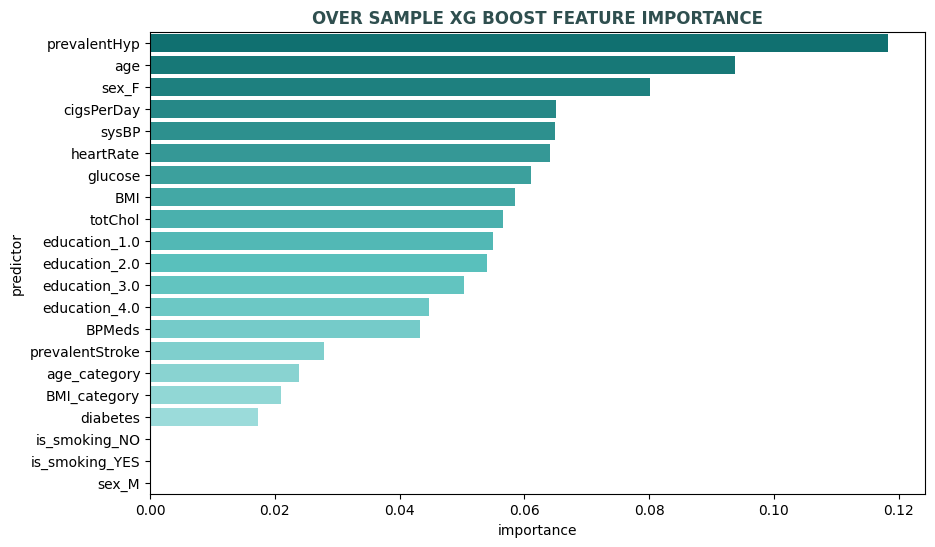

In [237]:
xg_boost_over.create_barplot_feature_importance('over sample')

###  XG BOOST  ON TOKEN_SMOTE DATAFRAME

-----


In [238]:
df_ts = pd.read_pickle('../data/cardio_processed_ts.pkl')
df_ts.head()

,age_category,BMI_category,BPMeds,prevalentStroke,prevalentHyp,diabetes,age,cigsPerDay,totChol,sysBP,BMI,heartRate,glucose,TenYearCHD,education_1.0,education_2.0,education_3.0,education_4.0,is_smoking_NO,is_smoking_YES,sex_F,sex_M
0,2.0,0.25,0,0,0,0,1.071429,0.15,-0.224138,0.722222,0.450931,1.000000,0.142857,1,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.5,0.25,0,0,1,0,-0.928571,0.00,-0.379310,1.462963,0.883744,-0.200000,-0.214286,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2,0.5,0.00,0,0,0,0,-0.214286,0.50,0.275862,-0.462963,-1.012582,0.866667,1.142857,0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.5,0.25,0,0,1,0,0.071429,1.00,-0.017241,1.092593,0.579768,-0.466667,1.142857,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,2.0,0.25,0,0,0,0,1.071429,1.50,0.120690,0.296296,0.209361,-0.333333,-0.071429,0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [239]:
xg_boost_ts = Xg_boost(df_ts, response_var)

In [240]:
xg_boost_ts.fit_model()

In [241]:
xgb_ts_results = xg_boost_ts.get_metrics('TS Xg Boost')
xgb_ts_results

,accuracy,precision,recall,f1,kappa,set,model
0,0.822026,0.318182,0.187919,0.236287,0.143051,test,TS Xg Boost
1,0.986094,1.000000,0.908840,0.952243,0.944127,train,TS Xg Boost


In [242]:
xg_boost_ts.create_df_feature_importance()

,predictor,importance
14,education_2.0,0.081741
3,prevalentStroke,0.080843
19,sex_F,0.076550
16,education_4.0,0.069680
7,cigsPerDay,0.067409
6,age,0.066499
0,age_category,0.060894
12,glucose,0.059127
9,sysBP,0.053633
13,education_1.0,0.051236


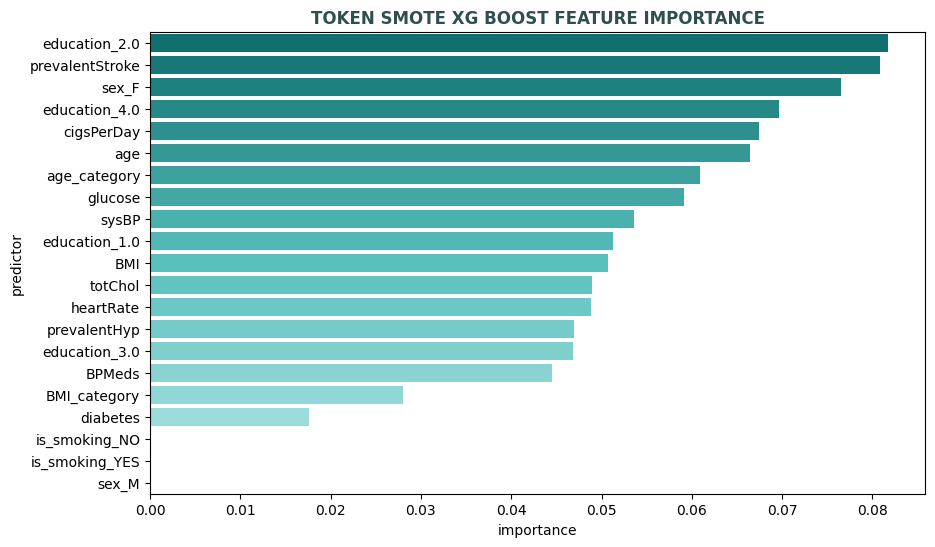

In [243]:
xg_boost_ts.create_barplot_feature_importance('token smote')

### SAVE RESULTS

-----

In [244]:
lr_dt_rf_results = pd.read_pickle('../data/LR_DT_RF_results.pkl')

In [245]:
all_results = pd.concat([lr_dt_rf_results, xgb_over_results, xgb_ts_results], axis = 0)
all_results

,accuracy,precision,recall,f1,kappa,set,model
0,0.674190,0.665874,0.665083,0.665478,0.347938,test,OVER Logistic Regression
1,0.668734,0.669075,0.681885,0.675419,0.337250,train,OVER Logistic Regression
0,0.860374,0.684211,0.087248,0.154762,0.125791,test,TS Logistic Regression
1,0.856300,0.744186,0.088398,0.158025,0.129837,train,TS Logistic Regression
0,0.725694,0.712471,0.732779,0.722482,0.451421,test,OVER Decision Tree Best
1,0.756328,0.754954,0.766814,0.760838,0.512512,train,OVER Decision Tree Best
0,0.853491,0.500000,0.020134,0.038710,0.027681,test,TS Decision Tree Best
1,0.848715,0.636364,0.019337,0.037534,0.028795,train,TS Decision Tree Best
0,0.785880,0.763982,0.811164,0.786866,0.572138,test,OVER Random Forest
1,0.835980,0.822702,0.861070,0.841449,0.671752,train,OVER Random Forest


In [246]:
all_results.to_pickle('../data/ALL_results.pkl')